In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
import re
# Setting up matplotlib
plt.style.use("ggplot")

In [ ]:
# Read the dataset
amazon_ratings = pd.read_csv('amazon.csv')

In [ ]:
# Data preprocessing
amazon_ratings = amazon_ratings.dropna()
amazon_ratings['rating_count'] = amazon_ratings['rating_count'].apply(lambda x: int(str(x).replace(',', '')))
amazon_ratings.drop(index=amazon_ratings[amazon_ratings['rating'] == '|'].index[0], inplace=True)
amazon_ratings['rating'] = amazon_ratings['rating'].astype('float')

In [ ]:
# Calculate weighted rating
popular_products = pd.DataFrame(amazon_ratings.groupby('product_id')['rating_count'].sum()).reset_index()
rating = amazon_ratings[['product_id', 'rating']]
most_popular = popular_products.merge(rating, on='product_id')
most_popular['weighted_rating'] = round((most_popular['rating'] * most_popular['rating_count'] +
                                        most_popular['rating'].mean() * most_popular['rating_count'].quantile(0.25)) /
                                       (most_popular['rating_count'] + most_popular['rating_count'].quantile(0.25)), 2)
most_popular = most_popular.sort_values(by='rating_count', ascending=False)

<Axes: xlabel='product_id'>

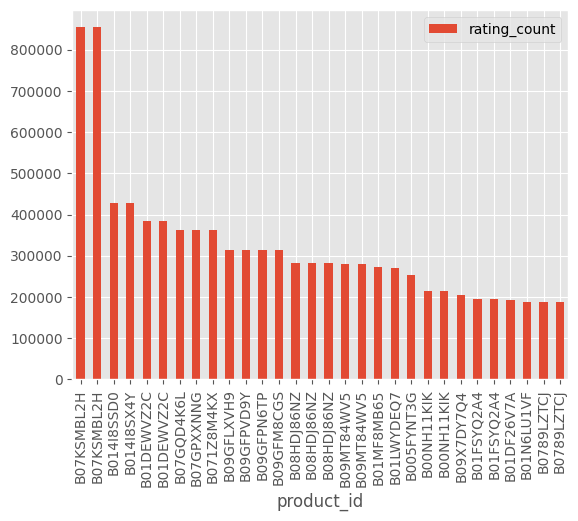

In [ ]:
# Plot most popular products
most_popular.head(30).plot(kind="bar", x='product_id', y='rating_count')

In [ ]:
# Recommendation System
product_descriptions = amazon_ratings[['product_id', 'about_product']].dropna()
product_descriptions['about_product'] = product_descriptions['about_product'].apply(lambda x: re.sub(r'\s+', ' ',
                                                                                                   re.sub(r'[^a-zA-Z ]', '', x)).lower())
product_descriptions['about_product'] = product_descriptions['about_product'].str.lstrip()

In [ ]:
# Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(product_descriptions['about_product'])

In [ ]:
# K-Means clustering
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10)
y_kmeans = kmeans.fit_predict(X)

In [ ]:
# Print top terms per cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(10):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 added
 usb
 typec
 enabled
 protection
 lightning
 lumia
 ends
 connector
 layer
Cluster 1:
 remote
 usb
 mouse
 tv
 laptop
 compatible
 wireless
 design
 use
 easy
Cluster 2:
 ipad
 pro
 iphone
 mini
 charging
 cable
 th
 plusiphone
 sync
 air
Cluster 3:
 earbuds
 sound
 bass
 mm
 ear
 hours
 music
 audio
 drivers
 playtime
Cluster 4:
 mp
 gb
 camera
 sim
 dual
 ram
 display
 processor
 storage
 mah
Cluster 5:
 watch
 smartwatch
 sports
 health
 display
 faces
 modes
 calling
 heart
 fireboltt
Cluster 6:
 cable
 usb
 charging
 data
 charge
 fast
 devices
 sync
 type
 speed
Cluster 7:
 connect
 ports
 tv
 product
 information
 usb
 features
 box
 hdmi
 dolby
Cluster 8:
 jar
 motor
 steel
 stainless
 food
 blades
 coffee
 blender
 blade
 grinding
Cluster 9:
 water
 heating
 heater
 heat
 room
 year
 element
 warranty
 power
 cord


In [ ]:
# Recommendation function
def show_recommendations(product):
    Y = vectorizer.transform([product])
    prediction = kmeans.predict(Y)
    print_cluster(prediction[0])

In [ ]:
def print_cluster(i):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

In [ ]:
show_recommendations("cutting tool")

Cluster 1:
 remote
 usb
 mouse
 tv
 laptop
 compatible
 wireless
 design
 use
 easy


In [ ]:
# RBM
rbm = BernoulliRBM(n_components=10, learning_rate=0.01, n_iter=10, random_state=0, verbose=True)

In [ ]:
# Build pipeline
pipeline = Pipeline(steps=[('vectorizer', vectorizer), ('rbm', rbm)])

In [ ]:
# Fit RBM
pipeline.fit(product_descriptions['about_product'])

[BernoulliRBM] Iteration 1, pseudo-likelihood = -5387.62, time = 2.61s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -3681.87, time = 3.41s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -2712.31, time = 2.41s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -2109.74, time = 3.76s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -1704.52, time = 3.09s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -1416.67, time = 1.80s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -1201.91, time = 2.92s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -1035.87, time = 3.86s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -902.79, time = 3.78s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -796.17, time = 2.72s


Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('rbm',
                 BernoulliRBM(learning_rate=0.01, n_components=10,
                              random_state=0, verbose=True))])

In [ ]:
# Get transformed vectors for all products
transformed_vectors = pipeline.named_steps['rbm'].transform(pipeline.named_steps['vectorizer'].transform(product_descriptions['about_product']))

In [ ]:
# Get recommendations for a given product
def get_recommendations(product_id, num_recommendations=3):
    product_index = product_descriptions.index[product_descriptions['product_id'] == product_id][0]
    product_vector = transformed_vectors[product_index]
    distances = np.linalg.norm(transformed_vectors - product_vector, axis=1)
    recommended_indices = np.argsort(distances)[1:num_recommendations+1]
    return product_descriptions.iloc[recommended_indices]

In [ ]:
# Get recommendations for ProductID 'B014I8SSD0'
recommendations = get_recommendations('B014I8SSD0', num_recommendations=5)
print("Recommendations for ProductID 'B014I8SSD0':")
print(recommendations)

Recommendations for ProductID 'B014I8SSD0':
      product_id                                      about_product
244   B098TV3L96  compatible devices highgrade remote control co...
281   B09PTT8DZF  accessibility meets universal compatibility en...
1019  B0141EZMAI  usb wifi adapter fast wireless transmission at...
90    B0141EZMAI  usb wifi adapter fast wireless transmission at...
670   B0856HNMR7  battery rockerz offers a playback time of up t...
